In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.abundance_classes as ac
import resources.chart_kwargs as ck

import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex


# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

sns.set_style('whitegrid')

a_fail_rate = 50

unit_label = 'p/100m'
reporting_unit = 100

# name of the output folder:
name_of_project = 'trans_report_all'

a_color = 'dodgerblue'

# set the maps
bassin_map = PILImage.open("resources/maps/survey_locations_all.jpeg")
bassin_pallette = {'rhone':'dimgray', 'aare':'salmon', 'linth':'tan', 'ticino':'steelblue', 'reuss':'purple'}

# define the feature level and components
comps = ['linth', 'rhone', 'aare', 'ticino']
comp_labels = {"linth":"Linth/Limmat", "rhone":"Rhône", 'aare':"Aare", "ticino":"Ticino/Cerisio", "reuss":"Reuss"}
comp_palette = {"Linth/Limmat":"dimgray", "Rhône":"tan", "Aare":"salmon", "Ticino/Cerisio":"steelblue", "Reuss":"purple"}

# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']

# columns needed
use_these_cols = ['loc_date' ,
                  '% to buildings',
                  '% to trans', 
                  '% to recreation',
                  '% to agg',
                  '% to woods',
                  'population',
                  'river_bassin',
                  'water_name_slug',
                  'streets km',
                  'intersects',
                  'length',
                  'groupname',
                  'code'
                 ]

# these are default
top_name = ["All survey areas"]

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# get your data:
survey_data = pd.read_csv('resources/results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/dims_data.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

city_map = dfBeaches['city']

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)
        
def make_plot_with_spearmans(data, ax, n):
    """Gets Spearmans ranked correlation and make A/B scatter plot. Must proived a
    matplotlib axis object.
    """    
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    
    return ax, corr, a_p

dfCodes.set_index("code", inplace=True)

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)
dfCodes = sut.shorten_the_value(["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G24", "description", "Plastic lid rings"], dfCodes)
dfCodes = sut.shorten_the_value(["G33", "description", "Lids for togo drinks plastic"], dfCodes)
dfCodes = sut.shorten_the_value(["G3", "description", "Plastic bags, carier bags"], dfCodes)
dfCodes = sut.shorten_the_value(["G204", "description", "Bricks, pipes not plastic"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

(transport)=
# The principal of causality

The hydrologic conditions of rivers have an effect on the distance and direction that litter, once introduced into a river,  will travel. Large low density objects will most likely be transported to the next reservoir or area of reduced flow. Once in the area of reduced flow surface currents and wind will transport low density objects untill they degrade and sink or land on the shore, a few may make it to the next reservoir. High density objects will only be transported if the flow velocity and turbulence of the water are sufficient to keep the objects off the bottom. Once high density items enter a low velocity zone they tend to settle or sink. {cite}`Kooi2018`

Current research suggests that freshwater environments act as both a source of plastic pollution to the marine environment, as well as a sink, potentially preventing a proportion from reaching the oceans. The presence of plastics in river and lake sediments is evidence of this sink, as is the large discrepancy between the plastic waste present in the ocean (1%) and the estimates of total waste input {cite}`winton`.

This has implications in the modeling and understanding of the fate of plastics long before they enter the ocean. Identifying accumulation areas of specific types of objects and the conditions that contribute or do not to the accumulation of those objects is part of understanding the environmental framework that those products are used in. This concerns fields such as waste management, pollution mitigation, life cycle assessment,  or product design. {cite}`Schwarz`

In Switzerland the elemination of waste and the management of litter is covered under chapter four of the _Federal act on the protection of the environment_ (LPE) {cite}`lpe` and the _Ordinance on the limitation and disposal of waste_ (OLED) {cite}`orddechets`. Article 31b of of the LPE places the responsibilty for the removal of litter on the cantons:

> Municipal waste, waste from roads and public sewage treatment plants, as well as waste whose holder cannot be identified (litter) or is insolvent, are disposed of by the cantons.

In reference to the LPE and OLED the federal court ruling of 2012 for the city of Bern concluded that:

> In the case of urban waste in the public space, the perpetrator often cannot be identified and that, consequently, those responsible further up the chain of causation may be required to contribute to the financing. {cite}`findechets` {cite}`tf138`

Cantons and municipalities maintain the responsibility of the elimination and management of litter because legally they are owners of the land within their boundaries. However, this ruling allows for *a more realistic application of the principle of causality*.

> If the person responsible for the release of municipal waste into the public space cannot be identified (littering or public garbage cans), it is permissible to consider companies or persons further up the chain of causality as producers of waste and to charge disposal fees to them (e.g. fast-food companies and similar businesses, or organisers of events that generate large quantities of waste on the public space) insofar as objectively founded criteria allow it. {cite}`findechets`

Furthermore, the _Federal law on water protection_ (LEAUX) is very clear on what constitutes water pollution.  

> Any harmful alteration of the physical, chemical or biological properties of the water. {cite}`leaux`

## The problem

The Federal courts ruling and the current law provide a common sense legal basis to attribute the responsibility for litter if the offender cannot be identified the responsibility may be attributed to another person or enterprise _"insofar as objectively founded criteria allow it"_.

__Definition:__ Secondary source (SS) is the next entity in the chain of causation that can be identified given objectvely founded criteria.

Exactly how the courts ruling could be put into practice at the municpal or cantonal level is less clear. It can be assumed that objective criteria includes:

1. quantities
2. locations
3. object type
4. material type
5. use case
6. dates

For a municpality that would mean an increase in operating costs equal to the amount required to establish _objectively founded criteria_ with no guarantee of the return on investment. Administrations that are looking to maintain balanced budgets are unliekly to divert resources to such an adventure. 

Most of the research on litter transport and accumulation in the aquatic environment is focused on continental scale movements that are concerned with trash quantities in the marine environment. While informative, these studies have little or no practical value for litter management at the local or municipal level up stream of the ocean. 

This knowledge gap and the required investment prevents regional adminstrations from fully applying the principle of causality to litter stocks within their boundaries. Objects like cigarette ends and food wrappers, 21% of total objects found in 2020, can be attributed to human behavior within 1500m of where it was found, see [_The land use profile_](luseprofile). 

However, other objects have no definitive geographic source or no clear association with an acitvity in proximity to where they are found. The most common of these objects are $\approx$ 40% of all litter items identified in 2020 - 2021. Thus there is a clear incentive to identify litter objects that are of local origin and those that may have arrived at the survey location by someother means. 

__Here we use the results of 385 litter surveys conducted in Switzerland from April 2020 - May 2021, to identify the most common liiter objects that were most likely left on site by beach users and those objects that were transported to the location by hydrologic action__.

## The test

The test compares the survey results of two groups of objects under two different land use profiles. The objects tested are based on the results of the Spearmans ranked correlation test on the survey results for the most common objects with respect to land use conditions (annex 1). The results of this test were used to create two groups of objects.

1. Objects that have multiple positive associations to land use features and one association is to buildings
2. Objects that have few or no postive associations to land use features

The locations were grouped according to the percent of land attributed to buildings, woods and agriculture.

### The objects

The most common objects are those objects that were either among the top ten most abundant objects or objects that were found in at least 50% of the surveys. The most common objects were first separated into two groups according to the previously cited criteria: 

1. __contributed (CG):__ objects that have multiple positive associations to land use features and one association is to buildings   
   * food and tobacco (FT)
     * cigarette ends
     * snack wrappers

2. __distributed (DG):__ objects that have few or no postive associations to land use features
   * fragmented plastics (FP)
     * fragmented plastics
     * fragmented foams
     
3. __other:__ objects that do not meet the above criteria

Two objects were selected from DG and CG.    
     
### The locations
     
The survey locations were grouped into two classess:

1. __urban:__ locations that have a percent of land attributed to buildings GREATER than the median
2. __rural:__ locations that have a percent of land attributed to buildings LESS than the median AND percent of land attributed to woods or agriculture greater than the median

The rural class had 142 surveys for 47 locations versus 158 surveys from 37 locations in the urban class.

### The hypothesis

If there is no significant evidence that a land use feature contributes to the accummulation of an object then the distribution of that object should be $\approx$ under all land use conditions.

> Null hypothesis: there is no statisticaly significant difference between survey results of DG objects at rural and urban locations.

> alternate hypothesis: there is a statisticaly significant difference between survey results of DG objects at rural and urban locations.

## The data


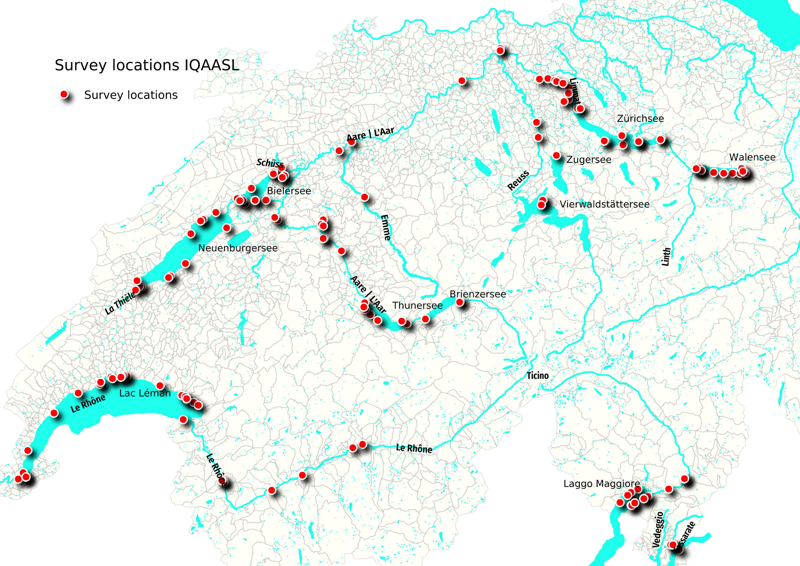

In [2]:
output = io.BytesIO()
bassin_map.thumbnail((800, 1200))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

*The survey locations 2020-2021: In total 385 litter-surveys were conducted touching 77 municipalities with a combined population of 1,735,000.*

In [3]:
# collect all the data and transform
a_data = survey_data.copy()

# save adated for testing
a_dated = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)].copy()

# format columns and slice by date
a_data['loc_date']=tuple(zip(a_data.location, a_data.date))
a_data['date']=pd.to_datetime(a_data['date'], format='%Y-%m-%d')
a_data = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)]
a_data['material'] = a_data.code.map(lambda x: code_material_map.loc[x])
a_data['city'] = a_data.location.map(lambda x: city_map.loc[x])

# combine survey areas
# combine lugano and maggiore
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'tresa', 'ticino' )

# combine reuss and linth
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'reuss', 'linth' )

# convert meters of streets to kilometers
a_data['streets'] = a_data.streets.astype('int')
a_data['streets km'] = a_data.streets/1000

# make a reporting unit column, keep the pcs_m column
a_data[unit_label] = (a_data.pcs_m *reporting_unit).astype('int')

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams, these will be called Gfoam
some_foams = ['G81', 'G82', 'G83']

# the codes for the fragmented plastics, these will be called Gfrags
some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())

# this extracts and aggregates the members of the two code groups, returns a dataframe
the_plast_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
the_foam_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
a_data = sut.replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])

# code and material totals
material_totals = a_data.groupby('material').quantity.sum()
code_totals = a_data.groupby(['code'], as_index=False).agg({unit_label:'mean', 'quantity':'sum'})

# cumulative statistics for each code
code_totals["% of total"] = ((code_totals.quantity/code_totals.quantity.sum())*100).round(2)
code_totals["fail"] = code_totals.code.map(lambda x: a_data[(a_data.code == x) & (a_data.quantity > 0)].loc_date.nunique())
code_totals["fail rate"] = ((code_totals.fail/a_data.loc_date.nunique())*100).astype('int')
code_totals.set_index('code', inplace=True)
code_totals['material'] = code_totals.index.map(lambda x: code_material_map[x])
code_totals['item'] = code_totals.index.map(lambda x: code_description_map[x])

# survey totals
dt_all = a_data.groupby(['loc_date','location','river_bassin', 'water_name_slug','city','date'], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})

#!! feature data!!#
fd = a_data.copy()

# column headers for the survey area data
fd['survey area'] = fd.river_bassin.map(lambda x: ut.use_this_key(x, comp_labels))

# gather the municpalities and the population:
fd_pop_map = dfBeaches.loc[fd.location.unique()][['city','population']].copy()
fd_pop_map.drop_duplicates(inplace=True)
fd_pop_map.set_index('city', drop=True, inplace=True)

# survey_totals feature data
fd_dt=dt_all.copy()
fd_dt['month'] = fd_dt.date.dt.month

# map survey total quantity to loc_date
fd_dq = fd_dt[['loc_date', 'quantity']].set_index('loc_date')

# material totals:
fd_mat_t = code_totals[['material', 'quantity']].groupby('material', as_index=False).quantity.sum()
fd_mat_t["% of total"] = fd_mat_t.quantity/fd_mat_t.quantity.sum()

# material totals
fd_mat_totals = fd_mat_t.sort_values(by='quantity', ascending=False)

mat_cols_to_use = {'material':'Material','quantity':'Quantity', '% of total':'% of total'}
fd_mat_totals['% of total'] =(fd_mat_totals['% of total']*100).round(1)
fd_mat_totals['quantity']=fd_mat_totals.quantity.map(lambda x: '{:,}'.format(x))
fd_mat_totals['% of total']=fd_mat_totals['% of total'].map(lambda x:F"{x}%")
fd_mat_t = fd_mat_totals[mat_cols_to_use.keys()].values

# summary statistics:
fd_n_samps = len(fd_dt)
fd_n_obj = fd.quantity.sum()
fd_n_locs = fd.location.nunique()
fd_n_munis = len(fd_pop_map.index)
fd_effected_population = fd_pop_map.sum()

fd_locs = fd.location.unique()
fd_samps = fd.loc_date.unique()

# gather the dimensional data for the time frame from dfDims
fd_dims= dfDims[(dfDims.location.isin(fd_locs))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# map the survey area name to the dims data record
m_ap_to_survey_area = fd[['location', 'river_bassin']].drop_duplicates().to_dict(orient='records')
a_new_map = {x['location']:x['river_bassin'] for x in m_ap_to_survey_area}

# make a survey area column in the dims data
fd_dims['survey area'] = fd_dims.location.map(lambda x: ut.use_this_key(x, a_new_map))

# map length and area from dims to survey data
st_map = fd_dims[['loc_date', 'length', 'area']].to_dict(orient='records')
amap = {x['loc_date']:{'length':x['length'], 'area':x['area']}for x in st_map}
trans = {x:F"{x}"for x in fd.loc_date.unique()}

def this_map(x,amap,trans, var='length'):
    try:
        data = amap[trans[x]][var]
    except:
        data = 0
    return data  
    
fd['length'] = fd.loc_date.map(lambda x:  this_map(x,amap,trans, var='length'))
fd['area'] = fd.loc_date.map(lambda x:  this_map(x,amap,trans, var='area'))
fd['water'] = fd.location.map(lambda x: dfBeaches['water'][x])

# these surveys are missing area and length data. 
# use the average values from all the surveys at that location to fill in the missing valuesf
make_lengths = fd.loc[fd.location.isin(['baby-plage-geneva','quai-maria-belgia'])].groupby('location').agg({'length':'mean', 'area':'mean'})
fd.loc[fd.loc_date == ('baby-plage-geneva', '2021-04-14'), 'length'] = 84
fd.loc[fd.loc_date == ('baby-plage-geneva', '2021-04-14'), 'area'] = 355
fd.loc[fd.loc_date.isin([('quai-maria-belgia', '2021-02-28'), ('quai-maria-belgia', '2021-01-31')]), 'length'] = 34
fd.loc[fd.loc_date.isin([('quai-maria-belgia', '2021-02-28'), ('quai-maria-belgia', '2021-01-31')]), 'area'] = 145

# gather the land use data for each location
luse_this_study = dfBeaches.loc[fd_locs].copy()
sns.set_style('whitegrid')

# the locations in the area of walensee are missing luse dataf
# we are only comparing locations that have a complete profile
lu_th_st = luse_this_study[luse_this_study.luse_total > 650]

#! the data minus the locations with incomplete land use data
#! including the % ranking of the land use features
grtr_10 = fd[fd.location.isin(lu_th_st.index)].copy()
dt_nw = grtr_10.groupby(use_these_cols[:-2], as_index=False).agg({unit_label:'sum'})

# the cumulative distributions for the different survey areas
ecdfs = {x:{} for x in comps}
ecdfs.update({"All surveys":{}})

for i, n in enumerate(luse_exp):
    for element in comps:
        the_data = ECDF(dt_nw[dt_nw.river_bassin == element][n].values)
        ecdfs[element].update({n:the_data})
        x, y = the_data.x, the_data.y           
    a_all_surveys =  ECDF(dt_nw[n].values)
    ecdfs["All surveys"].update({n:a_all_surveys})

Out of the 385 surveys only those that were on lakes were considered for this analysis.

*Survey results urban and rural locations March 2020 - May 2021. __Left__: Survey totals urban v/s rural, n=300. __Right__: distribution of survey results urban - rural with detail of code-group results.*

In [4]:
# summary stats table
# labels for the .describe function
change_names = {'count':'# samples',
                'mean':F"average {unit_label}",
                'std':'standard deviation',
                '25%':'25%', 
                '50%':'50%',
                '75%':'75%',
                'max':F"max {unit_label}",
                'min':F"min {unit_label}",
                'total objects':'total objects',
                '# locations':'# locations',
                'survey year':'survey year'
               }

def anew_dict(x):
    new_dict = {}
    for param in x.index:
        new_dict.update({change_names[param]:x[param]})
    return new_dict  

#the most abundant
most_abundant = code_totals.sort_values(by="quantity", ascending=False)[:10].index

# found greater than 50% of the time
l_grtr_50 = code_totals[code_totals['fail rate'] >= 50].index

# the most common
most_common = list(set([*most_abundant, *l_grtr_50]))

# eleminate surveys less than 10m and greater than 100m
# restricts surveys to locations on lakes
grtr_10 = grtr_10[(grtr_10.water == 'l')].copy()

# add different date identifiers
grtr_10['month'] = grtr_10.date.dt.month
grtr_10["eom"] = grtr_10.date.map(lambda x: pd.Period(x,freq='M').end_time.date())

def add_pctile_rate(x,ecdfs,feature):
    data = ecdfs['All surveys'][feature](x)
    return np.round((data*100),1)  

# get the percentile ranking of the land use features for each location
grtr_10['b_group'] = grtr_10["% to buildings"].map(lambda x: add_pctile_rate(x,ecdfs,"% to buildings"))
grtr_10['a_group'] = grtr_10["% to agg"].map(lambda x: add_pctile_rate(x,ecdfs,"% to agg"))
grtr_10['w_group'] = grtr_10["% to woods"].map(lambda x: add_pctile_rate(x,ecdfs,"% to woods"))
grtr_10['r_group'] = grtr_10["% to recreation"].map(lambda x: add_pctile_rate(x,ecdfs,"% to recreation"))

# group all the land use % into called profile
# this is a unique identifier for each location
grtr_10['profile'] = list(zip(grtr_10["% to buildings"], grtr_10["% to agg"], grtr_10["% to woods"], grtr_10["% to recreation"]))

# identify rural and urban location
grtr_10['rural'] = ((grtr_10.w_group > 50) | (grtr_10.a_group > 50) ) & (grtr_10.b_group < 50)
grtr_10['rural'] = grtr_10['rural'].where(grtr_10['rural'] == True, 'urban')
grtr_10['rural'] = grtr_10['rural'].where(grtr_10['rural'] == 'urban', 'rural')

# make a list of the objects by their association to buildings, streets recreation and thier use
# food and drink
cont = ["G27", "G30", "G178", "G200"]

# objects with no or few associations and not related to tobacco or food
dist = list(set(most_common) - set(cont))

# lables for the two groups and a label to catch all the other objects
grtr_10['group'] = 'other'
grtr_10['group'] = grtr_10.group.where(~grtr_10.code.isin(dist), 'DG')
grtr_10['group'] = grtr_10.group.where(~grtr_10.code.isin(cont), 'CG')

# survey totals of all locations with its land use profile
initial = ['loc_date','date','rural','group','a_group', 'b_group', 'r_group', 'w_group', 'streets', 'intersects']
grtr_10dt=grtr_10.groupby(initial, as_index=False).agg({unit_label:"sum", "quantity":"sum"})
grtr_10qkey = grtr_10dt[['loc_date', 'quantity']].set_index('loc_date')

# assigning survey totals to the cont and dist survey totals
def wtf(x, grtr_10key):
    return grtr_10key.loc[[x]].values[0][0]

# survey totals of contributed and distributed objects, 
second = ['loc_date', 'group', 'rural', 'date','eom', 'river_bassin','location','a_group', 'b_group', 'r_group', 'w_group', 'streets', 'intersects','profile']
grtr_10dtc=grtr_10.groupby(second, as_index=False).agg({unit_label:"sum", "quantity":"sum"})

In [5]:
# adding the survey total of all objects to each record
grtr_10dtc['dt']= grtr_10dtc.loc_date.map(lambda x:fd_dq.loc[[x], 'quantity'][0])

# calculating the % total of contributed and distributed at each survey
grtr_10dtc['pt']= grtr_10dtc.quantity/grtr_10dtc.dt

# the_dists = grtr_10dtc[grtr_10dtc.group == 'DG']
# the_conts = grtr_10dtc[grtr_10dtc.group == 'CG']

less_than = grtr_10dtc[(grtr_10dtc['rural'] == 'rural')].location.unique()
grt_than = grtr_10dtc[(grtr_10dtc['rural'] == 'urban')].location.unique()
grt_dtr = grtr_10dtc.groupby(['loc_date', 'date','rural'], as_index=False)[unit_label].agg({unit_label:"sum"})

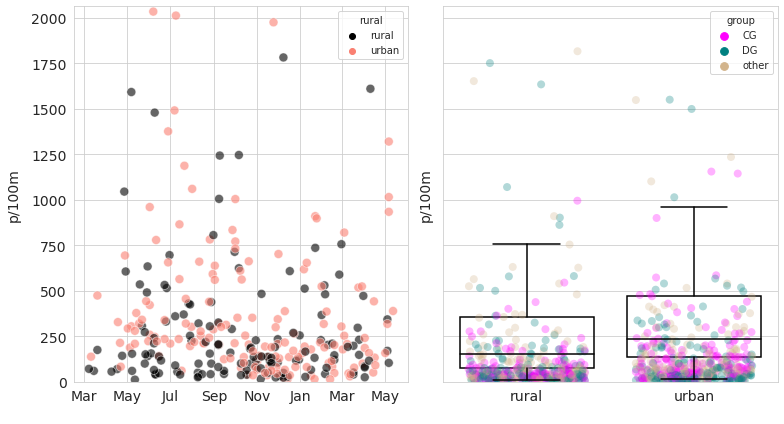

In [6]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)
fig, axs = plt.subplots(1,2, figsize=(11,6), sharey=True)

group_palette = {'CG':'magenta', 'DG':'teal', 'other':'tan'}
rural_palette = {'rural':'black', 'urban':'salmon' }

ax = axs[0]
sns.scatterplot(data=grt_dtr, x='date', y=unit_label, hue='rural', s=80, palette=rural_palette, alpha=0.6, ax=ax)

ax.set_ylim(0,grt_dtr[unit_label].quantile(.98)+50 )

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)

axtwo = axs[1]

box_props = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}

sns.boxplot(data=grt_dtr, x='rural', y=unit_label, dodge=False, showfliers=False, ax=axtwo, **box_props)
sns.stripplot(data=grtr_10dtc,x='rural', y=unit_label, ax=axtwo, zorder=1, hue='group', palette=group_palette, jitter=.35, alpha=0.3, s=8)
axtwo.set_ylabel(unit_label, **ck.xlab_k14)

ax.tick_params(which='both', axis='both', labelsize=14)
axtwo.tick_params(which='both', axis='both', labelsize=14)
axtwo.set_xlabel(" ")

plt.tight_layout()
plt.show()
plt.close()

*Summary data all survey totals*

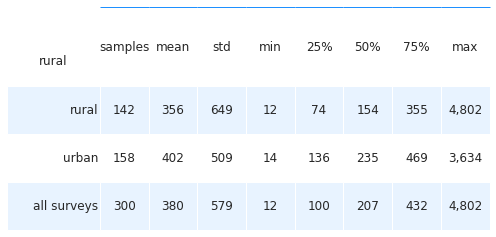

In [7]:
change_names = {'count':'# samples', 
                'mean':F"average {unit_label}",
                'std':'standard deviation', 
                'min p/50m':'min', '25%':'25%',
                '50%':'50%', '75%':'75%',
                'max':F"max {unit_label}", 'min':F"min {unit_label}",
                'total objects':'total objects',
                '# locations':'# locations',
                'survey year':'survey year'
               }

# convenience function to change the index names in a series
def anew_dict(x):
    new_dict = {}
    for param in x.index:
        new_dict.update({change_names[param]:x[param]})
    return new_dict  

# select data
data = grt_dtr

# get the basic statistics from pd.describe
desc_2020 = data.groupby('rural')[unit_label].describe()
desc_2020.loc['all surveys', ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']] = grt_dtr.groupby(['loc_date', 'date'])[unit_label].sum().describe().to_numpy()
desc = desc_2020.astype('int')
desc = desc.applymap(lambda x: F"{x:,}")
desc.rename(columns={'count':'samples'}, inplace= True)
desc.reset_index(inplace=True)

# make tables
fig, axs = plt.subplots(figsize=(7,3.4))

# summary table
# names for the table columns
a_col = [top_name[0], 'total']

axone = axs
ut.hide_spines_ticks_grids(axone)

a_table = axone.table(cellText=desc.values,  colLabels=desc.columns, colWidths=[.19,*[.1]*8], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,desc.values,desc.columns, s_et_bottom_row=False)


plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

## Differences between urban and rural survey totals

Survey results in rural locations had a lower median and mean than urban locations and all locations combined. The maximum and the minimum values as well as the highest standard deviation were recorded at rural locations.

### Confidence intervals (CIs) of the median survey results

The upper 95% of the median survey results from rural location is less than the 2.5% of the median survey result of both urban and combined survey results.

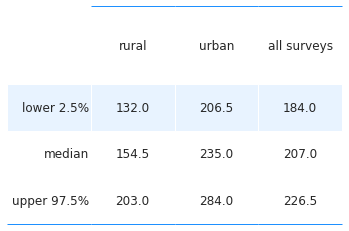

In [8]:
# this code was modified from this source:
# http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/recitations/bootstrapping.html
# if you want to get the confidence interval around another point estimate use np.percentile
# and add the percentile value as a parameter

def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

def compute_jackknife_reps(data, statfunction=None, stat_param=False):
    '''Returns jackknife resampled replicates for the given data and statistical function'''
    # Set up empty array to store jackknife replicates
    jack_reps = np.empty(len(data))

    # For each observation in the dataset, compute the statistical function on the sample
    # with that observation removed
    for i in range(len(data)):
        jack_sample = np.delete(data, i)
        if not stat_param:
            jack_reps[i] = statfunction(jack_sample)
        else:
            jack_reps[i] = statfunction(jack_sample, stat_param)          
        
    return jack_reps


def compute_a(jack_reps):
    '''Returns the acceleration constant a'''

    mean = np.mean(jack_reps)
    try:
        a = sum([(x**-(i+1)- (mean**-(i+1)))**3 for i,x in enumerate(jack_reps)])
        b = sum([(x**-(i+1)-mean-(i+1))**2 for i,x in enumerate(jack_reps)])
        c = 6*(b**(3/2))
        data = a/c
    except:
        print(mean)
    return data


def bootstrap_replicates(data, n_reps=1000, statfunction=None, stat_param=False):
    '''Computes n_reps number of bootstrap replicates for given data and statistical function'''
    boot_reps = np.empty(n_reps)
    for i in range(n_reps):
        if not stat_param:
            boot_reps[i] = statfunction(draw_bs_sample(data))
        else:
            boot_reps[i] = statfunction(draw_bs_sample(data), stat_param)     
        
    return boot_reps


def compute_z0(data, boot_reps, statfunction=None, stat_param=False):
    '''Computes z0 for given data and statistical function'''
    if not stat_param:
        s = statfunction(data)
    else:
        s = statfunction(data, stat_param)
    return stats.norm.ppf(np.sum(boot_reps < s) / len(boot_reps))


def compute_bca_ci(data, alpha_level, n_reps=1000, statfunction=None, stat_param=False):
    '''Returns BCa confidence interval for given data at given alpha level'''
    # Compute bootstrap and jackknife replicates
    boot_reps = bootstrap_replicates(data, n_reps, statfunction=statfunction, stat_param=stat_param)
    jack_reps = compute_jackknife_reps(data, statfunction=statfunction, stat_param=stat_param)

    # Compute a and z0
    a = compute_a(jack_reps)
    z0 = compute_z0(data, boot_reps, statfunction=statfunction, stat_param=stat_param)

    # Compute confidence interval indices
    alphas = np.array([alpha_level/2., 1-alpha_level/2.])
    zs = z0 + stats.norm.ppf(alphas).reshape(alphas.shape+(1,)*z0.ndim)
    avals = stats.norm.cdf(z0 + zs/(1-a*zs))
    ints = np.round((len(boot_reps)-1)*avals)
    ints = np.nan_to_num(ints).astype('int')

    # Compute confidence interval
    boot_reps = np.sort(boot_reps)
    ci_low = boot_reps[ints[0]]
    ci_high = boot_reps[ints[1]]
    return (ci_low, ci_high)


the_bcas = {}

an_int = 50

# rural cis
r_median = grt_dtr[grt_dtr.rural == 'rural'][unit_label].median()
a_result = compute_bca_ci(grt_dtr[grt_dtr.rural == 'rural'][unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
r_cis = {'rural':{"lower 2.5%":a_result[0], "median":r_median, "upper 97.5%": a_result[1] }}
the_bcas.update(r_cis)
# urban cis
u_median = grt_dtr[grt_dtr.rural == 'urban'][unit_label].median()
a_result = compute_bca_ci(grt_dtr[grt_dtr.rural == 'urban'][unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
u_cis = {'urban':{"lower 2.5%":a_result[0], "median":u_median, "upper 97.5%": a_result[1] }}
the_bcas.update(u_cis)
# all surveys
u_median = grt_dtr[unit_label].median()
a_result = compute_bca_ci(grt_dtr[unit_label].to_numpy(), .05, n_reps=5000, statfunction=np.percentile, stat_param=an_int)
all_cis = {'all surveys':{"lower 2.5%":a_result[0], "median":u_median, "upper 97.5%": a_result[1] }}

# combine the results:
the_bcas.update(all_cis)

# make a df
the_cis = pd.DataFrame(the_bcas)
the_cis.reset_index(inplace=True)

fig, axs = plt.subplots()

data = the_cis.values
collabels = the_cis.columns
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data, colLabels=collabels, colWidths=[*[.2]*5], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data,collabels, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.close()


*The 95% confidence interval of survey totals under urban and rural land use conditions*

The initial observation that the median survey result in urban locations is greater than the other locations is supported by the result of 95% CIs. The lower end of the urban ci is greater than the upper end of both rural survey locations and all survey locations.

## Survey results of CG and DG with respect to land use

Recall that the most common objects were grouped according to the value of the Spearmans ranked correlation test of p/100m with respect to the land use profile, (annex 1). Creating two groups, one group of objects that has a postive association with % of land attributed to buildings and one that does not. Cotton swabs are included with the objects that have few or no associations with landuse, beacuse they are normally expelled by water treatment plants directly into the nearest body of water.

The objects with no or few positive associations to land use charteristics (DG):

1. Cotton swabs
2. Expanded polystyrene foams > 5mm
3. Extruded foams
4. Industrial sheeting
5. Expanded foams < 5mm
6. Industrial pellets
7. Plastic construction waste
8. Fragmented plastics

The objects with multiple positive associations to land use charteristics (CG):

1. Cigarette ends
2. Snack wrappers
3. Glass bottles and pieces
4. Metal bottle tops



### Assessment of composition 

The ratio of DG to CG in the rural group was 1.7, in the urban group it was 0.81. On a per survey basis, DG were a greater percent of the total in all surveys from rural locations. In urban locations the ratio of DG to CG is the inverse of the rural locations and for approximately 20% of the surveys in urban locations the ratio of DG to CG is very close to 1.  

> Sample results from rural locations had a greater portion of trash attributed to fragmented plastics, construction plastics and foams.

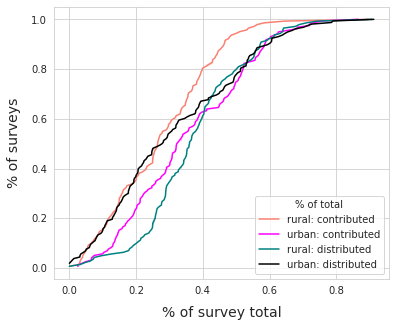

In [9]:
# combine the two object groups into one data frame
DG = "DG"
CG = "CG"

dists = grtr_10dtc[(grtr_10dtc.group == DG)][['loc_date', 'location', unit_label]].set_index('loc_date')
conts = grtr_10dtc[(grtr_10dtc.group == CG)][['loc_date', 'location',  unit_label]].set_index('loc_date')
conts.rename(columns={unit_label:CG}, inplace=True)
dists.rename(columns={unit_label:DG}, inplace=True)
c_v_d = pd.concat([dists, conts], axis=0)
c_v_d['dt'] = c_v_d[DG]/c_v_d[CG]

# the ratio of dist to cont under the two land use conditions
ratio_of_d_c_agg = c_v_d[c_v_d.location.isin(less_than)][DG].sum()/c_v_d[c_v_d.location.isin(less_than)][CG].sum()
ratio_of_d_c_urb= c_v_d[c_v_d.location.isin(grt_than)][DG].sum()/c_v_d[c_v_d.location.isin(grt_than)][CG].sum()

# chart that
fig, ax = plt.subplots(figsize=(6,5))

# get the ecdf of percent of total for each object group under each condition
# p of t urban
co_agecdf = ECDF(grtr_10dtc[(grtr_10dtc.location.isin(grt_than))&(grtr_10dtc.group.isin([CG]))]["pt"])
di_agecdf = ECDF(grtr_10dtc[(grtr_10dtc.location.isin(grt_than))&(grtr_10dtc.group.isin([DG]))]["pt"])

# p of t rural
cont_ecdf = ECDF(grtr_10dtc[(grtr_10dtc.location.isin(less_than))&(grtr_10dtc.group.isin([CG]))]["pt"])
dist_ecdf = ECDF(grtr_10dtc[(grtr_10dtc.location.isin(less_than))&(grtr_10dtc.group.isin([DG]))]["pt"])

sns.lineplot(x=cont_ecdf.x, y=cont_ecdf.y, color='salmon', label="rural: contributed", ax=ax)
sns.lineplot(x=co_agecdf.x, y=co_agecdf.y, color='magenta', ax=ax, label="urban: contributed")
sns.lineplot(x=dist_ecdf.x, y=dist_ecdf.y, color='teal', label="rural: distributed", ax=ax)
sns.lineplot(x=di_agecdf.x, y=di_agecdf.y, color='black', label="urban: distributed", ax=ax)

ax.set_xlabel("% of survey total", **ck.xlab_k14)
ax.set_ylabel("% of surveys", **ck.xlab_k14)
plt.legend(loc='lower right', title="% of total")

plt.show()

*Difference in composition of rural and urban litter surveys*

*Samples with a higher percentage of distributed objects and lower percentage of contributed objects were more likely in rural environments*

Under different land use conditions 9/10 of the most common objects are the same in rural and urban settings. There are two exceptions:

* _plastic construction waste_ made the top ten in rural settings
* _industrial pellets_ made the top ten in urban settings

The recorded quantities of _cigarette ends_, _glass bottles_ and _snack wrappers_ were greater under urban conditions.

*The most common objects under different land use profiles. __Left__: rural, __right__: urban*

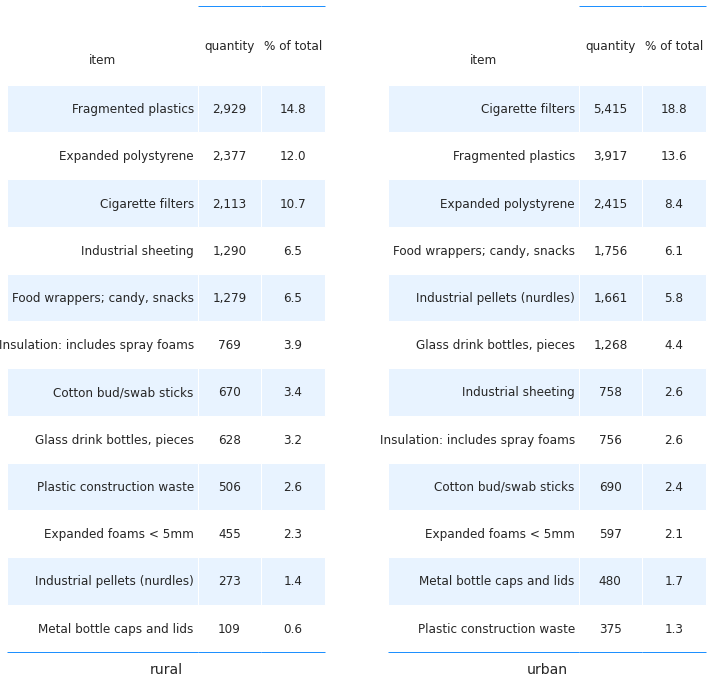

In [10]:
rur_10 = grtr_10[grtr_10.location.isin(less_than)&(grtr_10.code.isin(most_common))].groupby('code', as_index=False).quantity.sum().sort_values(by='quantity', ascending=False)
urb_10 = grtr_10[grtr_10.location.isin(grt_than)&(grtr_10.code.isin(most_common))].groupby('code', as_index=False).quantity.sum().sort_values(by='quantity', ascending=False)

rur_tot = grtr_10[grtr_10.location.isin(less_than)].quantity.sum()
urb_tot = grtr_10[grtr_10.location.isin(grt_than)].quantity.sum()

rur_10['item'] = rur_10.code.map(lambda x: code_description_map.loc[x])
urb_10['item'] = urb_10.code.map(lambda x: code_description_map.loc[x])

rur_10["% of total"] = ((rur_10.quantity/rur_tot)*100).round(1)
urb_10["% of total"] = ((urb_10.quantity/urb_tot)*100).round(1)

# make tables
fig, axs = plt.subplots(1, 2, figsize=(10,len(most_common)*.8))

# summary table
# names for the table columns
a_col = [top_name[0], 'total']

axone = axs[0]
axtwo = axs[1]

ut.hide_spines_ticks_grids(axone)
ut.hide_spines_ticks_grids(axtwo)

data_one = rur_10[['item', 'quantity', "% of total"]].copy()
data_two = urb_10[['item', 'quantity', "% of total"]].copy()

for a_df in [data_one, data_two]:
    a_df['quantity'] = a_df.quantity.map(lambda x: F"{x:,}")

a_table = axone.table(cellText=data_one.values,  colLabels=data_one.columns, colWidths=[.6,*[.2]*2], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,data_one.values,data_one.columns, s_et_bottom_row=True)

a_table = axtwo.table(cellText=data_two.values,  colLabels=data_one.columns, colWidths=[.6,*[.2]*2], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,data_one.values,data_one.columns, s_et_bottom_row=True)

axone.set_xlabel("rural", **ck.xlab_k14)
axtwo.set_xlabel("urban", **ck.xlab_k14)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

### Distribution of survey totals

The survey results of the DG are very similar under both land use classes, there is more variance as the reported value increases but not so much that the distributions diverge. Given the standard deviation of the samples and the high variance of beach-litter-survey data in general this is expected. {cite}`eubaselines`

The two sample Kolmogorov-Smirnov(KS) test(ks=0.073, p=0.808) of the two sets of survey results suggest that **the survey results of DG  may not be significantly diffrent between the two land use classes**. The results from the Mann-Whitney *U* (MWU) (U=11445.0, p=0.762) **suggeest that it is possible that the two distributions are the same.**{cite}`ks2sample` {cite}`mannwhitney`

*Empirical Cumulative Distribution (ECDF) of the survey results of DG and CG objects under the different land use classes*

*left: DG , right: CG*

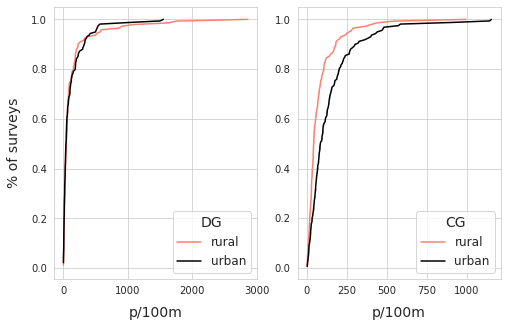

In [11]:
dist_results_agg = grtr_10dtc[(grtr_10dtc.location.isin(less_than))&(grtr_10dtc.group == DG)].groupby(['loc_date', 'group'])[unit_label].sum().values
dist_results_urb = grtr_10dtc[(grtr_10dtc.location.isin(grt_than))&(grtr_10dtc.group == DG)].groupby(['loc_date', 'group'])[unit_label].sum().values
a_d_ecdf = ECDF(dist_results_agg )
b_d_ecdf = ECDF(dist_results_urb )

cont_results_agg = grtr_10dtc[(grtr_10dtc.location.isin(less_than))&(grtr_10dtc.group == CG)].groupby('loc_date')[unit_label].sum().values
cont_results_urb = grtr_10dtc[(grtr_10dtc.location.isin(grt_than))&(grtr_10dtc.group == CG)].groupby('loc_date')[unit_label].sum().values
a_d_ecdf_cont = ECDF(cont_results_agg)
b_d_ecdf_cont = ECDF(cont_results_urb)

fig, ax = plt.subplots(1,2, figsize=(8,5))

axone = ax[0]
sns.lineplot(x=a_d_ecdf.x, y=a_d_ecdf.y, color='salmon', label="rural", ax=axone)
sns.lineplot(x=b_d_ecdf.x, y=b_d_ecdf.y, color='black', label="urban", ax=axone)
axone.set_xlabel(unit_label, **ck.xlab_k14)
axone.set_ylabel('% of surveys', **ck.xlab_k14)
axone.legend(fontsize=12, title=DG,title_fontsize=14)


axtwo = ax[1]
sns.lineplot(x=a_d_ecdf_cont.x, y=a_d_ecdf_cont.y, color='salmon', label="rural", ax=axtwo)
sns.lineplot(x=b_d_ecdf_cont.x, y=b_d_ecdf_cont.y, color='black', label="urban", ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel(' ')
axtwo.legend(fontsize=12, title=CG,title_fontsize=14)

plt.show()

On the other hand the CG survey results diverge almost immediately according to the land use class. This test results supports the decision to reject the null hypothesis of the Spearmans ranked correlation test for this group of codes and land use profile. The rural locations have less buildings and more agriculture or woods. The two conditions together should reduce the amount of tobacco and food wrappers for that class.

The KS and MWU tests both agree with the visual results that rural and urban CG survey results most likely come from different distributions and they are not equal (ks=0.284, pvalue<.0001), (U=7559.0, pvalue<.0001).

#### Difference of means

The average survey result of DG objects in rural locations was 139.86p/100m in urban locations and 117.75p/100m. A permutation test on the difference of means was conducted on the condition *rural* - *urban*. 

*Difference of means DG objects. $\mu_{rural}$ - $\mu_{urban}$, method=shuffle, permutations=5000.*

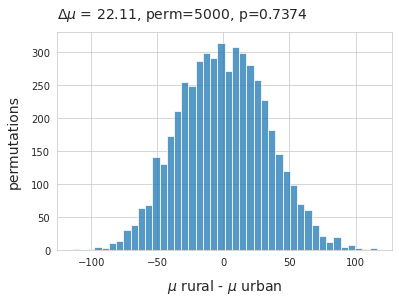

In [12]:
# print(stats.ks_2samp(dist_results_agg, dist_results_urb, alternative='two-sided', mode='auto'))
# print(stats.mannwhitneyu(dist_results_agg,dist_results_urb, alternative='two-sided'))

# #the results for contributed objects
# print(stats.ks_2samp(cont_results_agg, cont_results_urb, alternative='two-sided', mode='auto'))
# print(stats.mannwhitneyu(cont_results_agg, cont_results_urb, alternative='two-sided'))

# pemutation test: of difference of means HD objects
agg_dobj = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.group == DG)].groupby(['loc_date'], as_index=False)[unit_label].sum()
buld_obj = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.group == DG)].groupby(['loc_date'], as_index=False)[unit_label].sum()
# label the urban and rural results
agg_dobj['class'] = 'rural'
buld_obj['class'] = 'urban'

# merge into one 
objs_merged = agg_dobj.append(buld_obj)

# store the mean per class
the_mean = objs_merged.groupby('class')[unit_label].mean()

# store the difference
mean_diff = the_mean.loc['rural'] - the_mean.loc['urban']
new_means=[]
# permutation resampling:
for element in np.arange(5000):
    objs_merged['new_class'] = objs_merged['class'].sample(frac=1).values
    b=objs_merged.groupby('new_class').mean()
    new_means.append((b.loc['rural'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['rural'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ rural - $\mu$ urban", **ck.xlab_k14)
plt.show()

*Refuse to reject the null hypothesis that these two distributions may be the same*

The test of the difference of medians supports the observations that DG survey results occur at similar rates indifferent of the land use profile.

### Seasonal variations

Seasonal variations of beach litter suvey results has been documented under many conditions and many environments. In 2018 the SLR {cite}`slr` reported the maximum value in July and the minimum in November. The year 2020-2021 presents the same results.

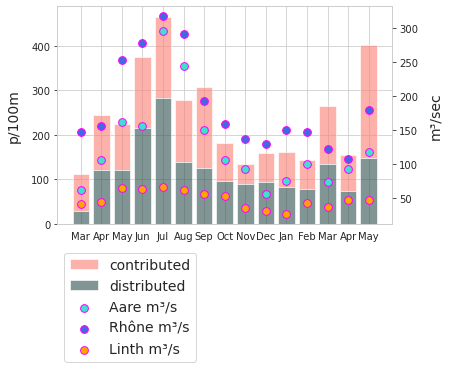

In [13]:
# the survey results to test
corr_data = grtr_10[(grtr_10.code.isin(most_common))].copy()
results_sprmns = {}
for i,code in enumerate(most_common):
    data = corr_data[corr_data.code == code]
    for j, n in enumerate(luse_exp):
        corr, a_p = stats.spearmanr(data[n], data[unit_label])
        results_sprmns.update({code:{"rho":corr, 'p':a_p}})

# helper dict for converting ints to months
months={
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sep',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}

m_dt = grtr_10.groupby(['loc_date', 'date','group'], as_index=False).agg({'quantity':'sum', unit_label:'sum'})

# sample totals all objects
m_dt_t = grtr_10.groupby(['loc_date','date','month', 'eom'], as_index=False).agg({unit_label:'sum'})
m_dt_t.set_index('date', inplace=True)

# data montlhy median survey results contributed, distributed and survey total
fxi=m_dt.set_index('date', drop=True)
data1 = fxi[fxi.group == CG][unit_label].resample("M").mean()
data2 = fxi[fxi.group == DG][unit_label].resample("M").mean()

# data3 = m_dt_t[unit_label].resample("M").mean()

# helper tool for months in integer order
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month


# the monthly average discharge rate of the three rivers where the majority of the samples are
aare_schonau = [61.9, 53, 61.5, 105, 161, 155, 295, 244, 150, 106, 93, 55.2, 74.6, 100, 73.6, 92.1]
rhone_scex =   [152, 144, 146, 155, 253, 277, 317, 291, 193, 158, 137, 129, 150, 146, 121, 107]
linth_weesen = [25.3, 50.7, 40.3, 44.3, 64.5, 63.2, 66.2, 61.5, 55.9, 52.5, 35.2, 30.5, 26.1, 42.0, 36.9]

fig, ax = plt.subplots()
    
this_x = [i for i,x in  enumerate(data1.index)]
this_month = [x.month for i,x in enumerate(data1.index)]

twin_ax = ax.twinx()
twin_ax.grid(None)

ax.bar(this_x, data1.to_numpy(), label='contributed', bottom=data2.to_numpy(), linewidth=1, color="salmon", alpha=0.6)
ax.bar([i for i,x in  enumerate(data2.index)], data2.to_numpy(), label='distributed', linewidth=1,color="darkslategray", alpha=0.6)

sns.scatterplot(x=this_x,y=[*aare_schonau[2:], np.mean(aare_schonau)], color='turquoise',  edgecolor='magenta', linewidth=1, s=60, label='Aare m³/s', ax=twin_ax)
sns.scatterplot(x=this_x,y=[*rhone_scex[2:], np.mean(rhone_scex)], color='royalblue',  edgecolor='magenta', linewidth=1, s=60, label='Rhône m³/s', ax=twin_ax)
sns.scatterplot(x=this_x,y=[*linth_weesen[2:], np.mean(linth_weesen), np.mean(linth_weesen)], color='orange', edgecolor='magenta', linewidth=1, s=60, label='Linth m³/s', ax=twin_ax)
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = twin_ax.get_legend_handles_labels()
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))

ax.set_ylabel(unit_label, **ck.xlab_k14)
twin_ax.set_ylabel("m³/sec", **ck.xlab_k14)

axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]

plt.xticks(ticks=axisticks, labels=labelsx)
plt.legend([*handles, *handles2], [*labels, *labels2], bbox_to_anchor=(0,-.1), loc='upper left', fontsize=14)

plt.show()

*monthly survey results and river discharge rates m³/second*

*April and May 2021 are rolling averages, data not available*

*source : https://www.hydrodaten.admin.ch/en/stations-and-data.html?entrance_medium=menu*

## The survey results of FP and FT with respect to land use

__Results of KS test and Mann Whitney U__

The survey results for FP objects is very similar up to $\approx$ the 85<sup>th</sup> percentile where the rural survey results are noticeably larger. Suggesting that extreme values for FP were more likely in rural locations. According to the KS test (ks=0.092, pvalue=0.50) and MWU test (U=11592.0, pvalue=0.62) the distribution of FP objects under the two land use classes is not significantly different and may be equal. 

The survey results for FT objects maintain the same features as the parent distribution. The results of the KS test (ks=0.29, pvalue<.001) and MWU test (U=7647.5, p<.001) agree with the results of the parent group, that there is a statisically relevant difference between the survey results under different land use classes.

*Left rural - urban: ECDF of survey results fragmented plastics and foams (FP)*

*Right rural - urban: ECDF of survey results cigarette ends and candy wrappers (FT)*

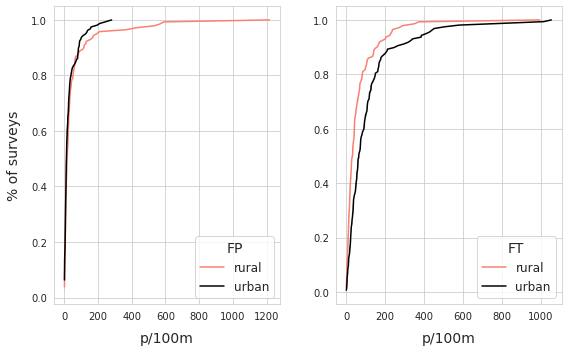

In [14]:
agg_dobj = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.code.isin(['Gfrags', 'Gfoam']))].groupby(['loc_date'])[unit_label].sum().values
buld_obj = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.code.isin(['Gfrags', 'Gfoam']))].groupby(['loc_date'])[unit_label].sum().values

a_d_ecdf = ECDF(agg_dobj)
b_d_ecdf = ECDF(buld_obj)

# print(len(a_d_ecdf.x))
# print(len(b_d_ecdf.x))
# print(a_d_ecdf(17), b_d_ecdf(15))
# print(np.quantile(a_d_ecdf.x,.65))
# print(np.quantile(b_d_ecdf.x, .65))

agg_cont = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.code.isin(['G27', 'G30']))].groupby(['loc_date'])[unit_label].sum().values
b_cont = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.code.isin(['G27', 'G30']))].groupby(['loc_date'])[unit_label].sum().values

a_c_ecdf = ECDF(agg_cont)
b_c_ecdf = ECDF(b_cont)

fig, ax = plt.subplots(1,2, figsize=(8,5))

axone = ax[0]
sns.lineplot(x=a_d_ecdf.x, y=a_d_ecdf.y, color='salmon', label="rural", ax=axone)
sns.lineplot(x=b_d_ecdf.x, y=b_d_ecdf.y, color='black', label="urban", ax=axone)
axone.set_xlabel(unit_label, **ck.xlab_k14)
axone.set_ylabel('% of surveys', **ck.xlab_k14)

axone.legend(fontsize=12, title='FP',title_fontsize=14)



axtwo = ax[1]
sns.lineplot(x=a_c_ecdf.x, y=a_c_ecdf.y, color='salmon', label="rural", ax=axtwo)
sns.lineplot(x=b_c_ecdf.x, y=b_c_ecdf.y, color='black', label="urban", ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel(' ')

# ax.legend(fontsize=12, title='TITLE (fs=30)',title_fontsize=30)

axtwo.legend(fontsize=12, title='FT',title_fontsize=14)
# axtwo.get_legend().set_title("Fragmented plastics")

plt.tight_layout()

plt.show()

In [15]:
# print(stats.ks_2samp(agg_cont , b_cont,  alternative='two-sided', mode='auto'))
# print(stats.mannwhitneyu(agg_cont , b_cont, alternative='two-sided'))

### FP and FT difference of means.

The average survey result of FP objects in rural locations was 22.93p/50m in urban locations it was 12p/50m. A permutation test on the difference of means was conducted on the condition *rural* - *urban*.

*Difference of means fragmented foams and plastics under the two differenent land use classes.*

*$\mu_{rural}$ - $\mu_{urban}$, method=shuffle, permutations=5000*

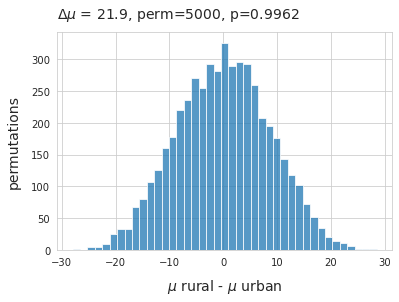

In [16]:
# pemutation test: of difference of means FP objects
agg_dobj = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.code.isin(['Gfrags', 'G89']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
buld_obj = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.code.isin(['Gfrags', 'G89']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
# label the urban and rural results
agg_dobj['class'] = 'rural'
buld_obj['class'] = 'urban'

# merge into one 
objs_merged = agg_dobj.append(buld_obj)

# store the mean per class
the_mean = objs_merged.groupby('class')[unit_label].mean()

# store the difference
mean_diff = the_mean.loc['rural'] - the_mean.loc['urban']
new_means=[]

# permutation resampling:
for element in np.arange(5000):
    objs_merged['new_class'] = objs_merged['class'].sample(frac=1).values
    b=objs_merged.groupby('new_class').mean()
    new_means.append((b.loc['rural'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['rural'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ rural - $\mu$ urban", **ck.xlab_k14)
plt.show()

*Refuse to reject the null hypotheses: there is no statisticaly significant difference between the two distributions* 

*Difference of means cigarette ends and snack wrappers under the two differenent land use classes.*

*$\mu_{rural}$ - $\mu_{urban}$, urban method=shuffle, permutations=5000*

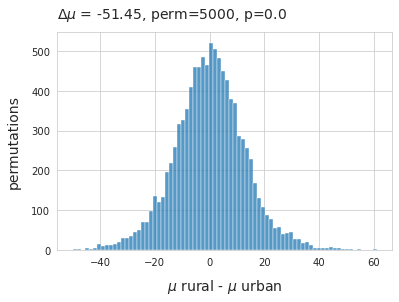

In [17]:
# pemutation test: of difference of means food objects
agg_cont = grtr_10[(grtr_10.location.isin(less_than))&(grtr_10.code.isin(['G27', 'G30']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
b_cont = grtr_10[(grtr_10.location.isin(grt_than))&(grtr_10.code.isin(['G27', 'G30']))].groupby(['loc_date'], as_index=False)[unit_label].sum()
# label the urban and rural results
agg_cont['class'] = 'rural'
b_cont['class'] = 'urban'

# merge into one 
objs_merged = agg_cont.append(b_cont)

# store the mean per class
the_mean = objs_merged.groupby('class')[unit_label].mean()

# store the difference
mean_diff = the_mean.loc['rural'] - the_mean.loc['urban']

# permutation resampling:
for element in np.arange(5000):
    objs_merged['new_class'] = objs_merged['class'].sample(frac=1).values
    b=objs_merged.groupby('new_class').mean()
    new_means.append((b.loc['rural'] - b.loc['urban']).values[0])
emp_p = np.count_nonzero(new_means <= (the_mean.loc['rural'] - the_mean.loc['urban'])) / 5000

# chart the results
fig, ax = plt.subplots()

sns.histplot(new_means, ax=ax)
ax.set_title(F"$\u0394\mu$ = {np.round(mean_diff, 2)}, perm=5000, p={emp_p} ", **ck.title_k14)
ax.set_ylabel('permutations', **ck.xlab_k14)
ax.set_xlabel("$\mu$ rural - $\mu$ urban", **ck.xlab_k14)
plt.show()

*Reject the null hypothesis: the two distributions are most likely not the same*

In [18]:
# a set of map points with the median survey value for each of the most 
# common codes and median survey value of DG and CG
a_maps = grtr_10[(grtr_10.code.isin(most_common))].groupby(['loc_date','location', 'code'], as_index=False)[unit_label].sum()

# median survey result for each code at each location
a_map = a_maps.groupby(['location', 'code'], as_index=False)[unit_label].median()

# pivot that and get codes as columns
som_vals = a_map.pivot(columns=['code'], index='location', values=unit_label)

# the median survey value of DG objects at each location
dgt = a_maps[a_maps.code.isin(dist)].groupby(['loc_date', 'location'], as_index=False)[unit_label].sum()
dgt = dgt.groupby('location')[unit_label].median()

# the median survey value of CG objects at each location
cgt = a_maps[a_maps.code.isin(cont)].groupby(['loc_date', 'location'], as_index=False)[unit_label].sum()
cgt = cgt.groupby('location')[unit_label].median()

# add columns to som_vals
som_vals['DG'] = som_vals.index.map(lambda x: dgt.loc[x])
som_vals['CG'] = som_vals.index.map(lambda x: cgt.loc[x])


these_beaches = dfBeaches.loc[som_vals.index][['latitude','longitude', 'bfsnum', 'city']]
a_map = pd.concat([these_beaches, som_vals], axis=1)
a_map.to_csv(F"{project_directory}/causality.csv")

## Implementation

The results of the test show that the DG objects are found at similar rates regardless of land use class. Therefore the null hypothesis can not be rejected. In contrast to the CG objects that have diverging rates depending on the land use profile. This applies to individual objects, in this example _fragmented plastics and fragmented foams_ represented the DG and _cigarette ends and candy wrappers_ represented the DG group.

Consider the quantity of _fractured plastics and foams_ under both landuse cases, 12'960 items were identified in the survey period. These objects have no definitive geographic source or no clear association with an acitvity in proximity to where they are found. If the current methods of cost particpation are applied, and the responsibile party for each object must be determined to satisfy the requirements of _objective criteria_ that would mean 12'960 different derrogations would need to be investigated. If the method was applied to all objects in this report that would be 32'249 investigations.

Even at the federal or cantonal level the increase in resources needed (time, money) to pursue each instance seperately would far outweigh any financial gain. A succesfull implementation of the principal of causality would include an objective assessment of the data and the aggregation of partnerships around specific objects or object categories.

### Collecting objective criteria

The requirement of objective criteria should not be construed as a hurdle or barrier to assigning responsibility. It is a way of ensuring that the principle of causality is applied appropriately. The survey results from IQAASL and SLR both provide the basic elements of objective criteria:

1. The gps coordinates where the objects were found
2. The date the objects were found
3. The quantity of objects found
4. A description of the object and its uses in the economy
5. The material type of the object
6. The dimensions of the area surveyed

There are limits to the information that can be extracted from beach litter surveys. These limitations are directly related to the costs associated with introducing more steps and in the survey process. Any additional measures that increase the cost of surveys to such a point that the total number of surveys for a region diminishes should be avoided. Calculating baseline values and measuring progress from one year to the next is dependent on the number of samples per region.

### Assigining secondary responsibility

Assigning secondary responsibility (SR) should be percieved and constructed as a partnership. The position on the causal chain of the responsible party requires this. In some instances it will be found that companies and other instituions have already implemented many iniatives in the _green space_ and they would like to see a return on their investments with regard to the environnement.

**To demonstrate a return on an investment their needs to be a baseline measurement, clear benchmarks and goals that have both a temporal and spatial definition.**

#### Geographic scale

__Municipal__

The results from the test indicate two clear distinctions between DG and CG. CG objects are $\approx$ 31% of all objects found in urban locations and $\approx$ 21% of the objects in rural locations. The survey results of CG objects having diverging and different distributions depending on the land use profile.

From this it could be concluded that the cause(s) of CG group litter are also more prevalent in urban areas and that the secondary cause of the litter is within 1500m of the survey location. In urban environments the number of potential secondary sources within 1500m of a survey location can be quite high. As such if the responsibility is generalized to all potential secondary sources within 1500m of a survey location then the cost per individual entity would be reduced.

The resources collected could be applied directly to the area in question. This could take the form of increased municipal services targeted to reduce the objects of concern. This allows business owners an opportunity to take an active role in the collection and the use of funds to improve the environment within their zone of activity.

__Regional__

The DG group has the particularity that it is distributed in $\approx$ rates indifferent of the land use and it makes up a larger proportion of the objects found than CG. This implies that the solution may be at a larger scale than the municpal boundaries. Assigning secondary responsibility for these objects may involve making partnerships with industry groups. This may be the prefered method given the objects in DG:

1. Expanded polystyrene
2. Plastic production pellets
3. Fragmented plastics
4. Cotton swabs
5. Industrial sheeting
6. Construction plastics

Fragmented plastics is the only object on the list that cannot be attributed to at least one industries that is present in all the survey areas covered by this analysis. Expanded polystyrene is used as an exterior insulation envelope in the construction industry and is also used in packaging to protect fragile objects during transport. Plastic production pellets are used to make platic objects in the injection molding process. Cotton swabs are often diverted to rivers and lakes after passing through a water treatment plant. Industrial sheeting is used in horticulture, transport and the construction industry.

In the cases where partnerships are prexisting with cantonal or federal administrations it could be as simple as developing a common strategy and establishing benchmarks and goals on a regional scale. For management purposes the regional scale is best defined as the common body of water of the institutions concerned.

#### Individual items

In cases such as the _plastic production pellet_ (G112), the use case of the item is definite and therfore the origin can be deterimined by searching for consumers of that product within 1500m of the survey location and then progressing upstream. This can be done by locating the survey locations on a map and then overlaying the locations of likely consumers or producers of the object in question.


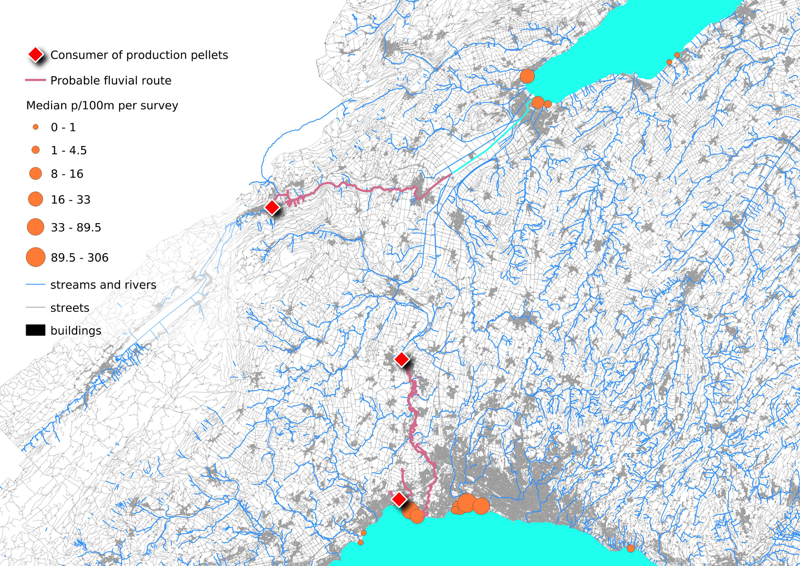

In [19]:
output = io.BytesIO()
bassin_map = PILImage.open("resources/images/causality.jpeg")
bassin_map.thumbnail((800, 1200))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

*Identifying secondary sources of specific litter items. Consumers or handlers of plastic production pellets and probable fluvial route to survey location. Venoge and Thiele rivers.*

*Enterprise names withheld*

### Conclusion

Beach litter survey results can be used to identify sources, trends, quantities and zones of accumulation. This is done using standard mathematical procedures, a defined sampling method and open source data analysis. This provides a method to compare baseline values of beach litter survey results in both space and time for any object in the inventory. 

By geolocating the survey results and using common search tools potential secondary sources can be identified for the most common objects. Thus allowing an objective and transparent application of the prinicipal of causality.  

In [20]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")


<br></br>
**This project was made possible by the Swiss federal office for the environment.**<br>

>Love what you do. ❤️<br>

*roger@hammerdirt.ch* pushed the run button on 2021-08-30.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>


## Annex

1. [surveyors](#us)
2. [municipalities, lakes, rivers](#munislakes)

The average length and survey area for each location was used to replace the missing values for each record.

### IQAASL surveyors

Hammerdirt staff:

1. Shannon Erismann, field operations manager
2. Helen Kurukulasuriya, surveyor
3. Débora Carmo, surveyor
4. Bettina Siegenthaler, surveyor
5. Roger Erismann, surveyor

Participating organizations:

1. Precious plastic leman
2. Association pour la sauvetage du Léman
3. Geneva international School
4. Solid waste management: École polytechnique fédéral Lausanne

### Municipalities, lakes and rivers with surveys

In [21]:
lakes = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'l')]['water_name'].unique()
rivers = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'r')]['water_name'].unique()
munis_joined = ', '.join(sorted(fd_pop_map.index))

muni_string = F"""**The municipalities in this report:**\n\n{munis_joined}
"""
md(muni_string)

**The municipalities in this report:**

Aarau, Allaman, Ascona, Beatenberg, Bellinzona, Bern, Biel/Bienne, Boudry, Bourg-en-Lavaux, Brienz (BE), Brissago, Brugg, Brügg, Burgdorf, Bönigen, Cheyres-Châbles, Cudrefin, Dietikon, Erlach, Estavayer, Freienbach, Gals, Gambarogno, Gebenstorf, Genève, Gland, Glarus Nord, Grandson, Hauterive (NE), Hünenberg, Kallnach, Köniz, Küsnacht (ZH), La Tour-de-Peilz, Lausanne, Lavey-Morcles, Le Landeron, Leuk, Ligerz, Locarno, Lugano, Luterbach, Lüscherz, Merenschwand, Minusio, Montreux, Neuchâtel, Nidau, Port, Préverenges, Quarten, Rapperswil-Jona, Richterswil, Riddes, Rubigen, Saint-Gingolph, Saint-Sulpice (VD), Salgesch, Schmerikon, Sion, Solothurn, Spiez, Stäfa, Thun, Tolochenaz, Unterengstringen, Unterseen, Versoix, Vevey, Vinelz, Walenstadt, Walperswil, Weesen, Weggis, Yverdon-les-Bains, Zug, Zürich


In [22]:
lakes_joined = ', '.join(sorted(lakes))

lake_string = F"""**The lakes in this report:**\n\n{lakes_joined}
"""
md(lake_string)

**The lakes in this report:**

Bielersee, Brienzersee, Lac Léman, Lago Maggiore, Lago di Lugano, Neuenburgersee, Quatre Cantons, Thunersee, Walensee, Zugersee, Zurichsee


In [23]:
rivers_joined = ', '.join(sorted(rivers))

river_string = F"""**The rivers in this report:**\n\n{rivers_joined}
"""
md(river_string)

**The rivers in this report:**

Aare, Aare|Nidau-Büren-Kanal, Cassarate, Dorfbach, Emme, Escherkanal, Jona, La Thièle, Limmat, Linthkanal, Maggia, Reuss, Rhône, Schüss, Seez, Sihl, Ticino


In [24]:
obj_string = '{:,}'.format(fd_n_obj)
surv_string = '{:,}'.format(fd_n_samps)
pop_string = '{:,}'.format(int(fd_effected_population[0]))

date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, {obj_string } objects were removed and identified in the course of {surv_string} surveys."
geo_context = F"Those surveys were conducted at {fd_n_locs} different locations."
admin_context = F"There are {fd_n_munis} different municipalities represented in these results with a combined population of approximately {pop_string}."
md(F"{date_quantity_context} {geo_context } {admin_context}")

For the period between 2020-03 and 2021-05, 54,713 objects were removed and identified in the course of 385 surveys. Those surveys were conducted at 143 different locations. There are 77 different municipalities represented in these results with a combined population of approximately 1,735,991.

### Results of Speramans ranked correlation test

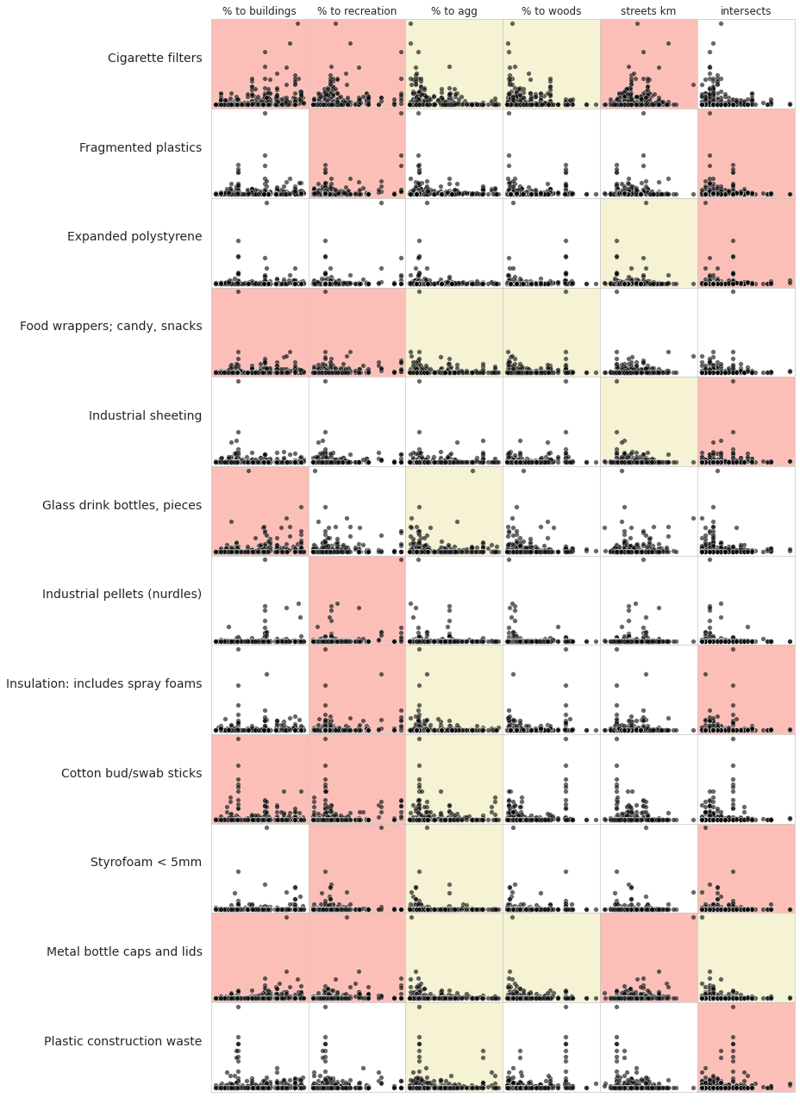

In [25]:
output = io.BytesIO()
bassin_map = PILImage.open("resources/images/land_use_correlation_27_0.png")
bassin_map.thumbnail((800, 1200))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
md(html)
